In [1]:
import numpy as np
from scipy import stats
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import theano.tensor as tt

%matplotlib inline

In [409]:
# data = pd.read_csv("charity_fundraising.csv")
raw_data = pd.read_csv("~/Downloads/charity_navigator_clean.csv", index_col=[0])

In [410]:
raw_data.head()

,accountability_score,administrative_expenses,charity_name,charity_url,city,cn_advisory,compensation_leader_compensation,compensation_leader_expense_percent,compensation_leader_title,excess_or_deficit_for_year,financial_score,fundraising_expenses,net_assets,organization_type,other_revenue,overall_score,payments_to_affiliates,program_expenses,state,total_contributions
0,89.0,164590,9to5 National Association of Working Women,https://www.charitynavigator.org/index.cfm?bay...,Milwaukee,NaN,53463.0,3.11,Executive Director,349718.0,90.56,111522,1350382,Human and Civil Rights : Advocacy and Education,49634.0,89.75,0,1440463,WI,1999023
1,86.0,1001560,'Aha Pūnana Leo,https://www.charitynavigator.org/index.cfm?bay...,Hilo,NaN,73500.0,1.47,Executive Director,1175965.0,85.92,54613,14773920,Education : Early Childhood Programs and Servi...,382540.0,85.95,0,3912270,HI,3339358
2,85.0,93957,AID FOR AIDS International,https://www.charitynavigator.org/index.cfm?bay...,New York,NaN,85000.0,0.99,Executive Director,-461502.0,77.65,248833,-770370,International : Development and Relief Services,0.0,80.96,0,8157850,NY,8039138
3,86.0,346867,Futures in Education,https://www.charitynavigator.org/index.cfm?bay...,Brooklyn,NaN,61220.0,0.78,Acting Executive Director,1872733.0,97.50,384550,11460087,"Education : Scholarship and Financial Support ,",-81726.0,89.94,0,7018262,NY,9704138
4,97.0,135195,Every Generation Ministries,https://www.charitynavigator.org/index.cfm?bay...,Temecula,NaN,74244.0,5.41,President,-103940.0,87.08,87436,723772,Religion : Religious Activities,32436.0,90.62,0,1148407,CA,1234662


In [415]:
raw_data["organization_type"] = raw_data.organization_type.str.strip().str.strip(
    " ,").str.replace(
        " ,This rating represents consolidated financial data for these organizations:", ""
)

In [416]:
np.sort(raw_data["organization_type"].unique())

array(['Animals : Animal Rights, Welfare, and Services',
       'Animals : Wildlife Conservation', 'Animals : Zoos and Aquariums',
       'Arts, Culture, Humanities : Libraries, Historical Societies and Landmark Preservation',
       'Arts, Culture, Humanities : Museums',
       'Arts, Culture, Humanities : Performing Arts',
       'Arts, Culture, Humanities : Performing Arts ,',
       'Arts, Culture, Humanities : Public Broadcasting and Media',
       'Community Development : Community Foundations',
       'Community Development : Housing and Neighborhood Development',
       'Community Development : Jewish Federations',
       'Community Development : Jewish Federations ,',
       'Community Development : United Ways',
       'Community Development : United Ways ,',
       'Education : Adult Education Programs and Services',
       'Education : Early Childhood Programs and Services',
       'Education : Education Policy and Reform',
       'Education : Scholarship and Financial Supp

In [406]:
# raw_data.query("organization_type == 'Animals : Wildlife Conservation ,This rating represents consolidated financial data for these organizations:'")
raw_data.query("charity_name == 'Ducks Unlimited'")

,accountability_score,administrative_expenses,charity_name,charity_url,city,cn_advisory,compensation_leader_compensation,compensation_leader_expense_percent,compensation_leader_title,excess_or_deficit_for_year,financial_score,fundraising_expenses,net_assets,organization_type,other_revenue,overall_score,payments_to_affiliates,program_expenses,state,total_contributions
36,96.0,6146668,Ducks Unlimited,https://www.charitynavigator.org/index.cfm?bay...,Memphis,NaN,511842.0,0.25,Chief Executive Officer,28422623.0,84.07,37813823,195923938,"Animals : Wildlife Conservation ,This rating r...",24159550.0,88.38,0,159565880,TN,207789444


In [417]:
data = raw_data[["organization_type", "charity_name", "total_contributions", "fundraising_expenses"]].dropna().query(
    "organization_type == 'International : Development and Relief Services' & total_contributions > 1000000")

In [418]:
data.groupby("organization_type")["total_contributions"].count()

organization_type
International : Development and Relief Services    342
Name: total_contributions, dtype: int64

In [419]:
data["efficiency"] = data["fundraising_expenses"]/data["total_contributions"].fillna(0)

In [420]:
data[["charity_name", "total_contributions", "fundraising_expenses", "efficiency"]].head()

,charity_name,total_contributions,fundraising_expenses,efficiency
2,AID FOR AIDS International,8039138,248833,0.030953
23,CURE International,23035192,3327969,0.144473
26,dZi Foundation,1453104,164621,0.113289
80,"Doctors Without Borders, USA",357438744,32351142,0.090508
83,DKT International,97787203,458429,0.004688


In [421]:
data[["charity_name", "total_contributions", "fundraising_expenses", "efficiency"]].sort_values("fundraising_expenses").head()

,charity_name,total_contributions,fundraising_expenses,efficiency
5720,SMVA Trust,1055776,5245,0.004968
7067,Music For Life Institute,1514922,6501,0.004291
2121,"India Development and Relief Fund, Inc. (IDRF)",2439373,7891,0.003235
3524,Association for India's Development,1881744,10055,0.005343
4086,All God's Children,1257496,11237,0.008936


In [422]:
data[["charity_name", "total_contributions", "fundraising_expenses", "efficiency"]].query("charity_name == 'Kids Alive International'")

,charity_name,total_contributions,fundraising_expenses,efficiency
1724,Kids Alive International,11819759,804500,0.068064


In [423]:
data_log = np.log(data[["total_contributions", "fundraising_expenses", "efficiency"]])
data_log["log_efficiency"] = data_log["fundraising_expenses"]/data_log["total_contributions"].fillna(0)

/Users/claus/.pyenv/versions/3.6.7/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


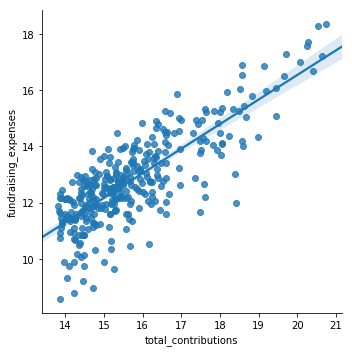

In [424]:
_ = sns.lmplot(x="total_contributions", y="fundraising_expenses", 
           data=data_log);

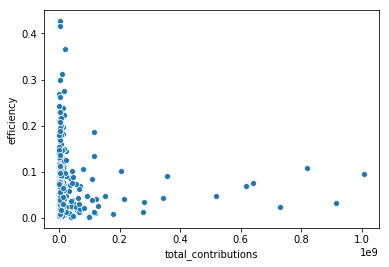

In [482]:
_ = sns.scatterplot(x="total_contributions", y="efficiency", data=data)

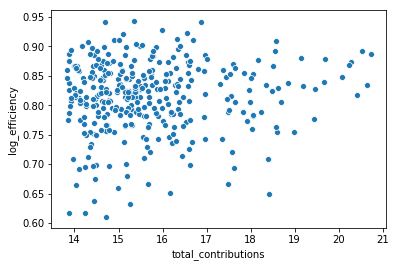

In [425]:
_ = sns.scatterplot(x="total_contributions", y="log_efficiency", data=data_log)

In [426]:
def get_indices(col):

    values = col.unique()
    idx = col.astype("category").cat.codes.values
    n_values = len(set(idx))

    return values, idx, n_values

In [427]:
charities, charity_idx, n_charities = get_indices(data["charity_name"])
# charity_idx = data.index.values
# n_charities = len(charity_idx)
contributions_obs = data["total_contributions"].astype(float).values

expenses_obs = data["fundraising_expenses"].astype(float).values

efficiency_obs = data["efficiency"].astype(float).values

In [428]:
n_charities #, charity_idx, charities

342

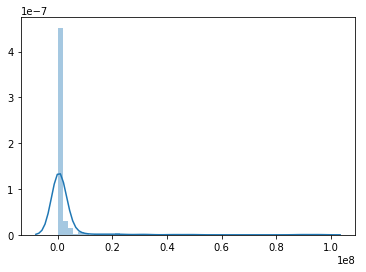

In [429]:
sns.distplot(expenses_obs)

In [430]:
efficiency_obs[efficiency_obs == 0]

array([], dtype=float64)

In [431]:
efficiency_obs[efficiency_obs == 0]

array([], dtype=float64)

In [449]:
with pm.Model() as model:
    
    a = pm.HalfNormal("a", sd=5, shape=n_charities)
    b = pm.HalfNormal("b", sd=5, shape=n_charities)
    efficiency = pm.Beta("efficiency", a, b, shape=n_charities, testval=efficiency_obs)

    # Define likelihood
    expected_expenses = pm.Deterministic("expected_expenses", efficiency * contributions_obs)
    expenses = pm.Poisson("expenses", mu=expected_expenses, observed=expenses_obs)


In [450]:
model

In [451]:
# for v in model.free_RVs:
#     print(v, np.exp(v.tag.test_value))

In [452]:
# with pm.Model() as log_model:
    
#     log_efficiency = pm.Normal("efficiency", shape=n_charities)
    
#     mu = np.log(contributions_obs) + log_efficiency[charity_idx]
#     sd = pm.HalfNormal("sd", sd=2)
    
#     log_expenses = pm.Normal("expenses", mu=mu, sd=sd, observed=np.log(expenses_obs))


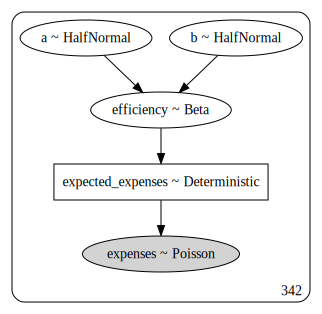

In [453]:
pm.model_to_graphviz(model)

In [454]:
n_samples = 10000
n_chains = 3
seed = 42
SAMPLE_KWARGS = {
    'draws': n_samples,
    'tune': int(n_samples/2),
    'chains': n_chains,
    'cores': n_chains,
    'random_seed': [seed + i for i in range(n_chains)] if n_chains > 1 else seed,
    'nuts_kwargs': {'target_accept': 0.9}
}

In [472]:
i = 1
charities[i], expenses_obs[i], contributions_obs[i], efficiency_obs[i]

('CURE International', 3327969.0, 23035192.0, 0.14447324771592962)

In [456]:
with model:
    trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [efficiency, b, a]
Sampling 3 chains: 100%|██████████| 45000/45000 [02:41<00:00, 278.82draws/s]


/Users/claus/.pyenv/versions/3.6.7/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


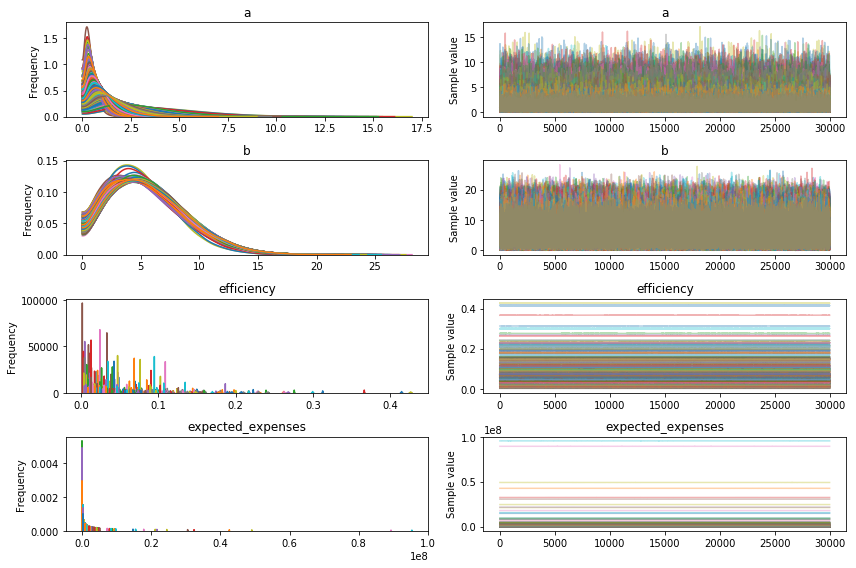

In [457]:
with model:
    pm.traceplot(trace, combined=True)

In [459]:
efficiency_obs[:5]

array([0.0309527 , 0.14447325, 0.11328921, 0.09050821, 0.00468803])

In [461]:
trace["efficiency"].mean(axis=0)[:5]

array([0.03095209, 0.14447309, 0.11328865, 0.09050825, 0.00468801])

In [464]:
trace["efficiency"][:, :5].shape

(30000, 5)

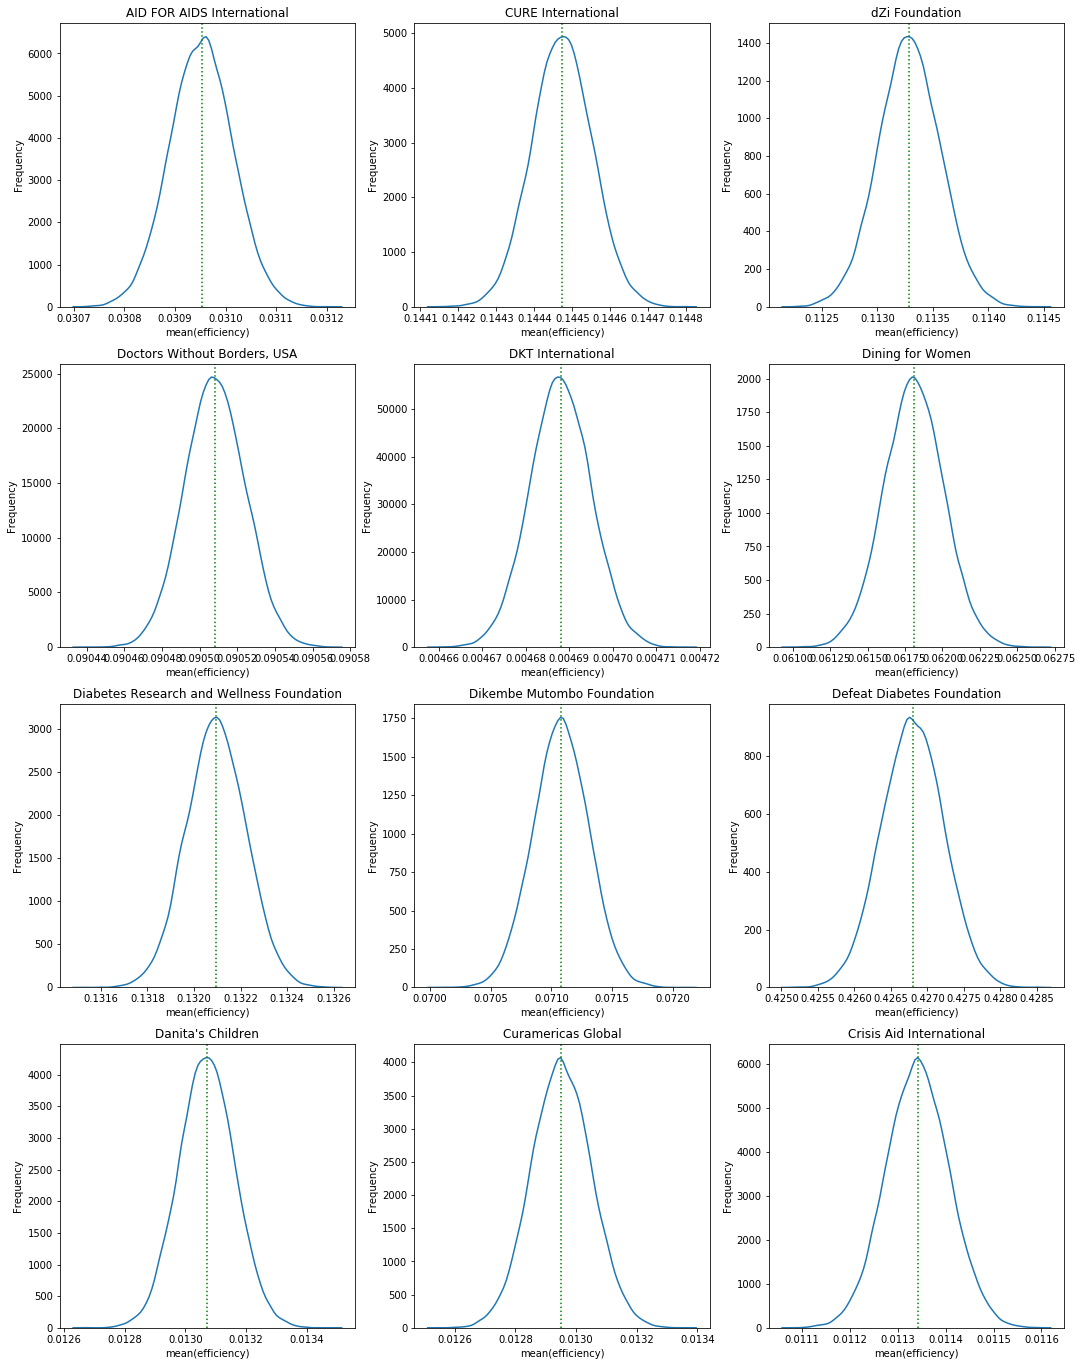

In [481]:
n = 12
n_cols = 3
n_rows = int(np.ceil(n/n_cols))

_, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows), squeeze=False)
axes = axes.flatten()

for i in range(0, n):
    ax = axes[i]
    dt = trace['efficiency'][:, i]
    sns.distplot(dt, kde=True, hist=False, ax=ax)
    ax.axvline(efficiency_obs[i], c='g', linestyle='dotted')
    ax.set(title=f'{charities[i]}', xlabel='mean(efficiency)', ylabel='Frequency');